# Hate-Speech-Detection
## (Naive Bayes vs SVM)

## Import all the libraries
<b>Pandas, seaborn</b>  and <b>matplotlib</b> to manipulate the dataset and for visualization<br>
<b>nltk</b> for text preprocessing<br>
<b>sklearn</b> for feature extraction, model building<br>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import re
import string

## Import the Dataset
Import and check the data

In [2]:
# Load the text data
data = pd.read_csv("labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


The dataset contains Three classes 0 for Hate speech, 1 for offensive speech and 2 for Non Hate and Offensive speech.<br>
Replace 1 with 0 to combine hate and offensive speech.<br>
Replace 2 with 1 to make data standard.<br>

In [3]:
data.replace(to_replace=1, value=0, inplace=True)
data.replace(to_replace=2, value=1, inplace=True)
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,3,0,3,0,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,3,0,3,0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,1,0,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Map the classes column to label where it's 0 to Hate Speech and 1 to No Hate and Offensive

In [4]:
data["labels"] = data["class"].map({0: "Hate Speech", 
                                    1: "No Hate and Offensive"})
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      1   
1           0      3            0                   3        0      0   
2           1      3            0                   3        0      0   
3           3      3            0                   1        0      0   
4           4      6            0                   6        0      0   

                                               tweet                 labels  
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...            Hate Speech  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...            Hate Speech  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...            Hate Speech  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...            Hate Speech  


Create a DataFrame with only tweet and label column

In [5]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate Speech
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate Speech
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate Speech
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate Speech


## Preprocess the text

Clean the text.<br>
Do word tokanization.<br>
filter stopwords.<br>
Removing duplicate data.<bR>

In [6]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [7]:
#applying pre-processing to text data
data.tweet=data['tweet'].apply(clean)

In [8]:
# removing duplicate data
tweetData = data.drop_duplicates("tweet")

In [9]:
# to see updated number of columns as duplicates entries are removed
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   labels  24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


To see the data after pre-processing.

In [10]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



Lemmatizing the data.

In [11]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [12]:
#lemmatizing the processed data
tweetData.loc[:, 'tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))

In [13]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [14]:
# to see distribution of labels
tweetData['labels'].value_counts()

labels
Hate Speech              20393
No Hate and Offensive     4113
Name: count, dtype: int64

## Visualize the Data

### Use count plot to visualise the count of the different labels

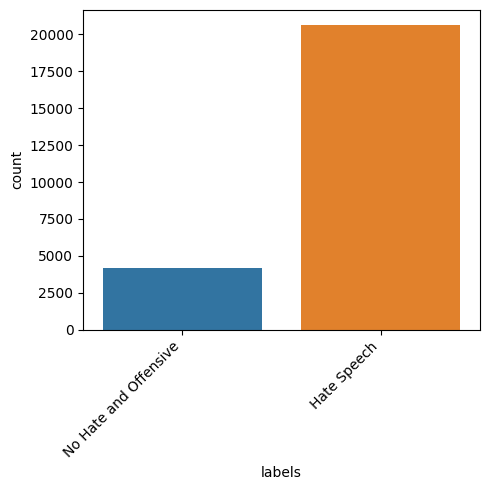

In [15]:
# to visualize the data using a count plot
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Use Pie-chart to visualise the count of the different labels

Text(0.5, 1.0, 'Distribution of sentiments')

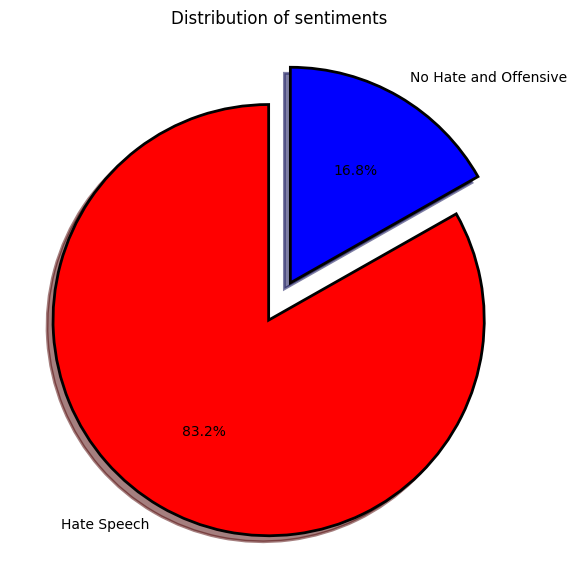

In [16]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = data['labels'].value_counts()
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

#here 0 indicates hate speech, 1 indicates no hate & offensive

View few non-hate tweets

In [17]:
# visualizing non-hate tweets
non_hate_tweets = data[data.labels=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,labels
0,rt mayasolovely woman shouldnt complain cleani...,No Hate and Offensive
40,momma said pussy cats inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,allaboutmanfeet woof woof hot soles,No Hate and Offensive
67,allyhaaaaa lemmie eat oreo amp dishes one oreo...,No Hate and Offensive


In [18]:
non_hate_tweets.value_counts()

tweet                                                                                                        labels               
best asian massage park slope top rated spa                                                                  No Hate and Offensive    14
grand opening top class oriental massage perfect                                                             No Hate and Offensive     8
best asian massage brooklyn park slope top rated spa                                                         No Hate and Offensive     5
international law enforcement operation disrupts shylock banking malware pcworld international law enforcem  No Hate and Offensive     3
trash                                                                                                        No Hate and Offensive     3
                                                                                                                                      ..
jundishes get wasp spray shoots feet cheaper be

View few hate tweets

In [19]:
# visualizing hate tweets
hate_tweets = data[data.labels=='Hate Speech']
hate_tweets.head()

,tweet,labels
1,rt boy dats coldtyga dwn bad cuffin dat hoe place,Hate Speech
2,rt urkindofbrand dawg rt ever fuck bitch start...,Hate Speech
3,rt cganderson vivabased look like tranny,Hate Speech
4,rt shenikaroberts shit hear might true might f...,Hate Speech
5,tmadisonx shit blows meclaim faithful somebody...,Hate Speech


In [20]:
hate_tweets.value_counts()

tweet                                                                                                         labels     
bitch                                                                                                         Hate Speech    23
pussy                                                                                                         Hate Speech    12
hoe                                                                                                           Hate Speech     9
hoes aint loyal                                                                                               Hate Speech     8
faggot                                                                                                        Hate Speech     8
                                                                                                                             ..
indirect ass little bitches like know fucking number live                                                     

### Visualizing non-hate tweets using word cloud

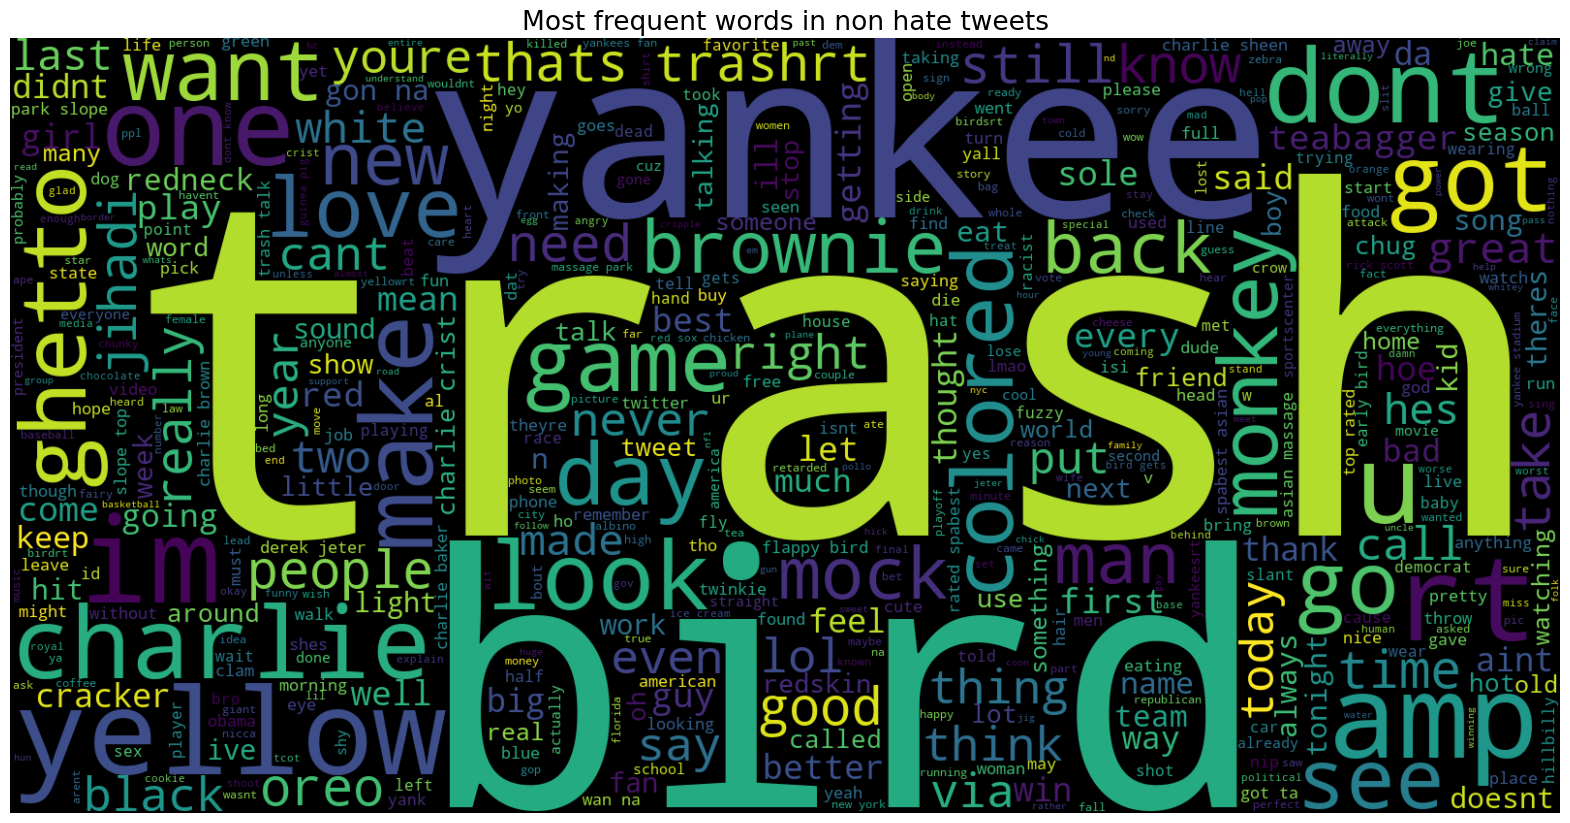

In [21]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

### Visualizing hate tweets using word cloud

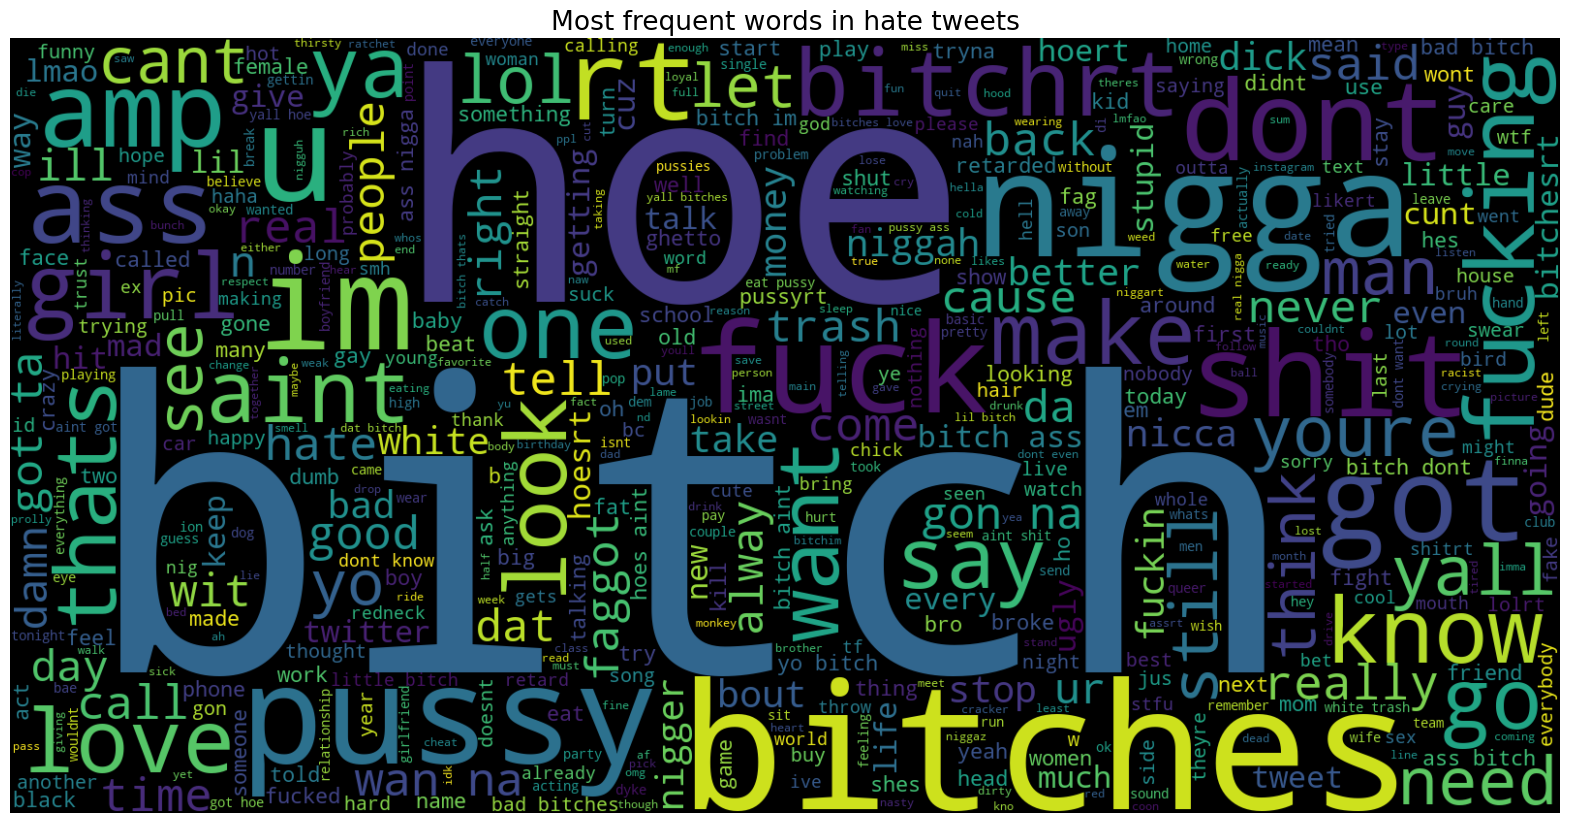

In [22]:
# visualizing hate tweets using word cloud
text=''.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in hate tweets", fontsize=19)
plt.show()

## Feature Extraction on text data

In [23]:
texts = tweetData['tweet']
labels = tweetData['labels']

### Bag-of-words model

Find only the single word features

In [24]:
# Create a bag-of-words model
Count_vectorizer = CountVectorizer()
Count_features = Count_vectorizer.fit_transform(texts)
# texts = Count_vectorizer.transform(texts)

# Get the feature names
Count_feature_names = Count_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(Count_feature_names)}\n")
print("First 200 features: \n", format(Count_feature_names[:20]))

Number of features: 30134

First 200 features: 
 ['aa' 'aaaaaaaaand' 'aaahhhhh' 'aahahah' 'aaliyah' 'aaliyahhhm'
 'aaliyahhlovee' 'aamaadmiparty' 'aampt' 'aamu' 'aan' 'aanderlusting'
 'aap' 'aaron' 'aaroncarter' 'aaronkeplin' 'aaronmacgruder' 'aaronthegoat'
 'aaronworthing' 'aaryn']


### Bi-gram vectorizer

Gives at most two word features

In [25]:
# Create an bi-gram vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_features = bigram_vectorizer.fit_transform(texts)

# Get the feature names
bigram_feature_names = bigram_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(bigram_feature_names)}\n")
print("First 200 features: \n", format(bigram_feature_names[:20]))

Number of features: 161774

First 200 features: 
 ['aa' 'aa classes' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begins' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aaliyah curving'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhlovee' 'aaliyahhlovee yu'
 'aamaadmiparty' 'aamaadmiparty mix' 'aampt' 'aampt ackin' 'aamu']


### Tri-gram vectorizer

Gives at most three word features

In [26]:
# Create a tri-gram vectorizer
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_features = trigram_vectorizer.fit_transform(texts)
final_texts = trigram_vectorizer.transform(texts)

# Get the feature names
trigram_feature_names = trigram_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(trigram_feature_names)}\n")
print("First 200 features: \n", format(trigram_feature_names[:20]))

Number of features: 310426

First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt']


### TF-IDF vectorizer

Gives one word features

In [27]:
# Create a TF-IDF vectorizer
Tfidf_vectorizer = TfidfVectorizer()
Tfidf_features = Tfidf_vectorizer.fit_transform(texts)

# Get the feature names
Tfidf_feature_names = Tfidf_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(Tfidf_feature_names)}\n")
print("First 200 features: \n", format(Tfidf_feature_names[:20]))

Number of features: 30134

First 200 features: 
 ['aa' 'aaaaaaaaand' 'aaahhhhh' 'aahahah' 'aaliyah' 'aaliyahhhm'
 'aaliyahhlovee' 'aamaadmiparty' 'aampt' 'aamu' 'aan' 'aanderlusting'
 'aap' 'aaron' 'aaroncarter' 'aaronkeplin' 'aaronmacgruder' 'aaronthegoat'
 'aaronworthing' 'aaryn']


## Predection Model Building.

### Split Train and Test data

Split Train and Test data using text got after tri-gram vectorization.<br>
Train:Test split is done with ratio 7:3 and random state 42.<br>

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(final_texts, labels, test_size=0.3, random_state=42)

Check the shape of the data

In [29]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (17154, 310426)
Size of Y_train (17154,)
Size of X_test (7352, 310426)
Size of Y_test (7352,)


### Classifiers
Choose a classifier.<br>
Fit the train data.<br>
Predict the test data.<br>

Evaluate the performance of the classifier.<br>
Evaluate accuracy, precision, recall, and f1 score.<br>

Create and show confusion matrix and classification report<br>
Visualizing confusion matrix<br>

#### Naive Bayes classifier

Accuracy: 0.9270946681175191
Precision: 0.9554616384915474
Recall: 0.957328990228013
F1 score: 0.9563944028636512
[[5878  262]
 [ 274  938]]


                       precision    recall  f1-score   support

          Hate Speech       0.96      0.96      0.96      6140
No Hate and Offensive       0.78      0.77      0.78      1212

             accuracy                           0.93      7352
            macro avg       0.87      0.87      0.87      7352
         weighted avg       0.93      0.93      0.93      7352



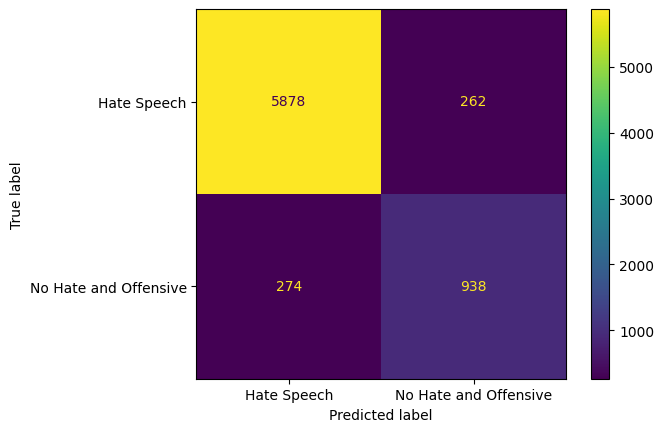

In [30]:
# Create a Naive Bayes classifier
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, Y_train)
NB_predictions = NB_classifier.predict(X_test)

# Evaluate the performance of the classifier
NB_accuracy = accuracy_score(Y_test, NB_predictions)
NB_precision = precision_score(Y_test, NB_predictions, pos_label="Hate Speech")
NB_recall = recall_score(Y_test, NB_predictions, pos_label="Hate Speech")
NB_f1 = f1_score(Y_test, NB_predictions, pos_label="Hate Speech")

# Print the evaluation metrics
print("Accuracy:", NB_accuracy)
print("Precision:", NB_precision)
print("Recall:", NB_recall)
print("F1 score:", NB_f1)

# Create a confusion matrix
NB_cm = confusion_matrix(Y_test, NB_predictions)

# printing confusion matrix and classification report
print(NB_cm)
print("\n")
print(classification_report(Y_test, NB_predictions))

#for visualizing confusion matrix
# style.use('classic')
disp = ConfusionMatrixDisplay(confusion_matrix=NB_cm, display_labels=NB_classifier.classes_)
disp.plot()

#### SVM classifier

Accuracy: 0.9292709466811752
Precision: 0.9355238685678859
Recall: 0.9830618892508143
F1 score: 0.9587039390088945
[[6036  104]
 [ 416  796]]


                       precision    recall  f1-score   support

          Hate Speech       0.94      0.98      0.96      6140
No Hate and Offensive       0.88      0.66      0.75      1212

             accuracy                           0.93      7352
            macro avg       0.91      0.82      0.86      7352
         weighted avg       0.93      0.93      0.92      7352



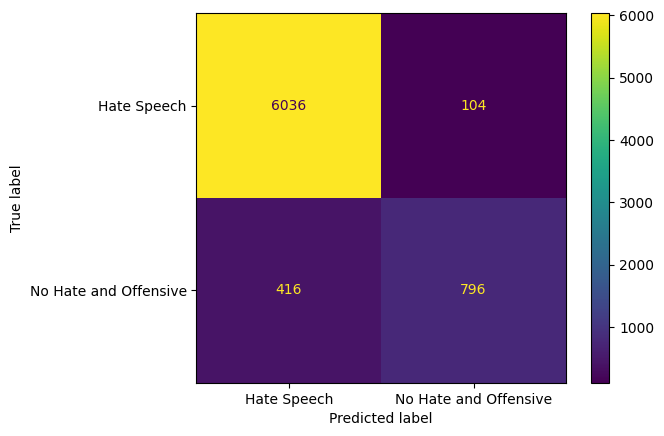

In [31]:
# Create an SVM classifier
SVM_classifier = SVC(probability=True)
SVM_classifier.fit(X_train, Y_train)
SVM_predictions = SVM_classifier.predict(X_test)

# Evaluate the performance of the classifier
SVM_accuracy = accuracy_score(Y_test, SVM_predictions)
SVM_precision = precision_score(Y_test, SVM_predictions, pos_label="Hate Speech")
SVM_recall = recall_score(Y_test, SVM_predictions, pos_label="Hate Speech")
SVM_f1 = f1_score(Y_test, SVM_predictions, pos_label="Hate Speech")

# Print the evaluation metrics
print("Accuracy:", SVM_accuracy)
print("Precision:", SVM_precision)
print("Recall:", SVM_recall)
print("F1 score:", SVM_f1)

# Create a confusion matrix
SVM_cm = confusion_matrix(Y_test, SVM_predictions)

#printing confusion matrix and classification report
print(SVM_cm)
print("\n")
print(classification_report(Y_test, SVM_predictions))

#for visualizing confusion matrix
# style.use('classic')
disp = ConfusionMatrixDisplay(confusion_matrix=SVM_cm, display_labels=SVM_classifier.classes_)
disp.plot()

## ROC curve and AUC score

Find Prediction Probability for the Classifiers

In [32]:
Y_test = [1 if label == "No Hate and Offensive" else 0 for label in Y_test]
NB_pred_prob = NB_classifier.predict_proba(X_test)[:,1]
SVM_pred_prob = SVM_classifier.predict_proba(X_test)[:,1]

Find false positive rate, true positive rate and thresholds using ROC curve.<br>
Find AUC score using false positive rate, true positive rate.<br>

In [33]:
# Calculate ROC curve and AUC score
NB_fpr, NB_tpr, NB_thresholds = roc_curve(Y_test, NB_pred_prob)
SVM_fpr, SVM_tpr, SVM_thresholds = roc_curve(Y_test, SVM_pred_prob)

NB_auc = auc(NB_fpr, NB_tpr)
SVM_auc = auc(SVM_fpr, SVM_tpr)

### Visualize the ROC curve of the Classifiers

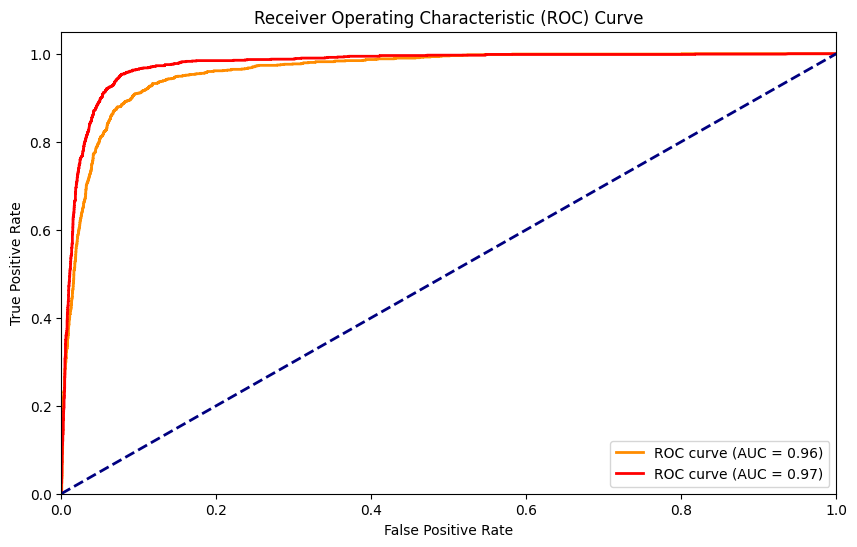

NB AUC score: 0.9601530837122798
SVM AUC score: 0.9748499666741917


In [34]:
# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(NB_fpr, NB_tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {NB_auc:.2f})')
plt.plot(SVM_fpr, SVM_tpr, color='red', lw=2, label=f'ROC curve (AUC = {SVM_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print("NB AUC score:", NB_auc)
print("SVM AUC score:", SVM_auc)